In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,auc,average_precision_score,roc_curve,precision_recall_curve, precision_recall_fscore_support


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

<h3 style="color:orange">Hyperparameters</h3>

In [74]:
optimizer="lbfgs"
epoch=[100,1000,5000][2]
missing_ratio=[0.05,0.075,0.1,0.2][-1]

Threshold=0.6

if "temp" not in os.listdir("./"): os.makedirs("./temp")          #for debuging

print(f"\u001b[33mOptimizer: \u001b[0m{optimizer}\n\u001b[33mEpochs: \u001b[0m{epoch}")
print(f"\u001b[33mMissing Ratio: \u001b[0m{missing_ratio*100}%")

Optimizer: lbfgs
Epochs: 5000
Missing Ratio: 20.0%


<h3 style="color:orange">Load Data</h3>

In [75]:
data=pd.read_csv("./dataset/UCI_Credit_Card.csv")
print(data.shape)

## checking duplicate and null values
print(f"\u001b[33mSum Duplicate:\u001b[0m {data.duplicated().sum()}")
print(f"\u001b[33mSum NaN Value: \u001b[0m{data.isna().sum().sum()}")


(30000, 25)
Sum Duplicate: 0
Sum NaN Value: 0


In [76]:
# data
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<h3 style="color:orange">data visialization</h3>

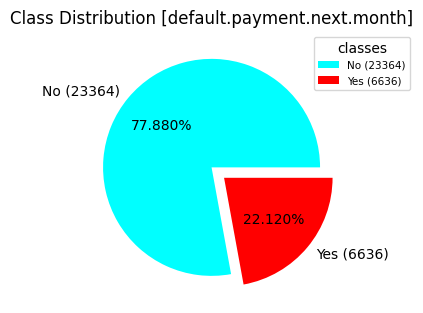

In [77]:
y=data.iloc[:,-1]
plt.figure(figsize=(3.5, 5))
plt.pie(y.value_counts().values,labels=[f"No ({y.value_counts()[0]})",f"Yes ({y.value_counts()[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution [default.payment.next.month]")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

<h3 style="color:orange">add misssing values in AGE and BILL_AMT and marriage</h3>

In [78]:
sample_size=int(data.shape[0]*missing_ratio)
column_change=["AGE","MARRIAGE","BILL_AMT1"]


dataA=copy.copy(data)

for x in column_change:
    M_idx=np.random.choice(dataA.shape[0],size=sample_size,replace=False)
    
    dataA.iloc[M_idx,data.columns.get_loc(x)]=np.nan

print(dataA.isna().sum())

ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                      6000
AGE                           6000
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     6000
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


<h3 style="color:orange">dataA: fill with median</h3>

When handling missing data, there are two common ways to estimate values to replace NaN entries:
- Fill with **mean** (Sensitive to outliers)  
- Fill with **median** (Insensitive to outliers)

When we fill missing values using the mean, there is a chance of introducing imbalance into the dataset if extreme outliers exist in the data. This could cause issues in further analysis.  

If the dataset has some skewness or outliers, we prefer to use the median instead of the mean to fill missing values, as it does not introduce much imbalance into the dataset.


In [79]:
NA_column=dataA.columns[(dataA.isna().sum()>0)].values

dataA[NA_column] = dataA[NA_column].apply(lambda col: col.fillna(col.median()))
print(dataA.isna().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


<h3 style="color:orange">DataB: fillna using linear regrssion model</h3>

Linear Regression Imputation estimates missing values of one variable by modeling its linear relationship with other observed variables. The imputation assumes that the data are Missing At Random (MAR) — that is, the probability of a value being missing depends only on other observed features, not on the missing value itself.

let say weh have dataset with $X=\{X_1,\dots,X_n\}$ features and $X_j$ has missing values then we split data into 2 parts
- $X_j^{observed}$ where $X_j$ is observed [train set]
- $X_j^{missing}$ where $X_j$ is missing [test set]

then we can model the relationship between $X_j$ and the other features of X as
$$X_j=\beta+\beta_1X_1+\dots+\beta_{j-1}X_{j-1}+\beta_{j+1}X_{j+1}+\dots+\beta_n+X_n+\epsilon$$

one we estimate $\hat{\beta}$ we can predict missing values as:
$$\hat{X}_j^{missing}=\hat{\beta}_0 \sum\limits_{k\ne j}^n \hat{\beta}_kX_k^{missing}$$



In [80]:
dataB=copy.copy(data)

st=StandardScaler()
dataB.iloc[:,:-1]=st.fit_transform(dataB.iloc[:,:-1])


M_idx=np.random.choice(dataB.shape[0],size=sample_size,replace=False)
dataB.iloc[M_idx,data.columns.get_loc("AGE")]=np.nan

print(dataB.isna().sum())
# dataB

ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           6000
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                        0
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


In [81]:
dx_train=dataB.loc[dataB["AGE"].notna()].drop(["AGE"],axis=1)
dy_train=dataB.loc[dataB["AGE"].notna()]["AGE"]

dx_test=dataB.loc[dataB["AGE"].isna()].drop(["AGE"],axis=1)

print(f"\u001b[33mx_train: \u001b[0m{dx_train.shape}\t\u001b[33my_train: \u001b[0m{dy_train.shape}")
print(f"\u001b[33mx_test: \u001b[0m{dx_test.shape}")

model=LinearRegression()
model.fit(dx_train,dy_train)
d_pred=model.predict(dx_test)

dataB.loc[dataB["AGE"].isna(),"AGE"]=d_pred

print(dataB.isna().sum())

x_train: (24000, 24)	y_train: (24000,)
x_test: (6000, 24)
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


<h3 style="color:orange">DataC: fillna using Decision Tree regressor model OR KNN regressor model</h3>

In [82]:
dataC=copy.copy(data)

st=StandardScaler()
dataC.iloc[:,:-1]=st.fit_transform(dataC.iloc[:,:-1])

M_idx=np.random.choice(dataC.shape[0],size=sample_size,replace=False)
dataC.iloc[M_idx,data.columns.get_loc("AGE")]=np.nan

print(dataC.isna().sum())

ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           6000
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                        0
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


In [83]:
### using decision tree
# dx_train=dataC.loc[dataC["AGE"].notna()].drop(["AGE"],axis=1)
# dy_train=dataC.loc[dataC["AGE"].notna()]["AGE"]

# dx_test=dataC.loc[dataC["AGE"].isna()].drop(["AGE"],axis=1)

# print(f"\u001b[33mx_train: \u001b[0m{dx_train.shape}\t\u001b[33my_train: \u001b[0m{dy_train.shape}")
# print(f"\u001b[33mx_test: \u001b[0m{dx_test.shape}")

# dtr=DecisionTreeRegressor()
# dtr.fit(dx_train,dy_train)

# d_pred=dtr.predict(dx_test)

# dataC.loc[dataC["AGE"].isna(),"AGE"]=d_pred

# print(dataC.isna().sum())

Text(0, 0.5, 'Mean square error')

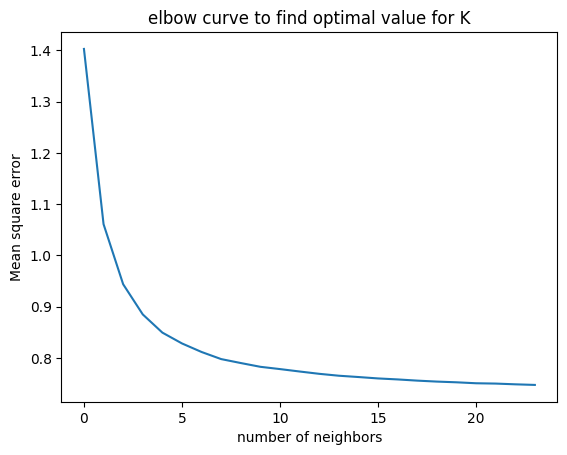

In [84]:
dx_train=dataC.loc[dataC["AGE"].notna()].drop(["AGE"],axis=1)
dy_train=dataC.loc[dataC["AGE"].notna()]["AGE"]

dx_test=dataC.loc[dataC["AGE"].isna()].drop(["AGE"],axis=1)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse=[]
for i in range(1,dx_train.shape[1]+1):
    model=KNeighborsRegressor(n_neighbors=i)
    # model.fit(dx_train,dy_train)

    score=cross_val_score(model,dx_train,dy_train,scoring="neg_mean_squared_error",cv=cv,n_jobs=-1)
    mse.append(-score.mean())

plt.plot(np.array(mse))
plt.title("elbow curve to find optimal value for K")
plt.xlabel("number of neighbors")
plt.ylabel("Mean square error")

Based above Plot optimal value for K should be in between 6-9 beacuse after 9 it flattens out so as optimimal point we select K=8

In [85]:
K=[6,8][0]
model=KNeighborsRegressor(n_neighbors=K)

model.fit(dx_train,dy_train)
d_pred=model.predict(dx_test)

dataC.loc[dataC["AGE"].isna(),"AGE"]=d_pred

print(dataC.isna().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


<h3 style="color:orange">DataD: remove rows with null values</h3>

In [86]:
dataD=copy.copy(data)
print(dataD.shape)
M_idx=np.random.choice(dataD.shape[0],size=sample_size,replace=False)
dataD.iloc[M_idx,data.columns.get_loc("AGE")]=np.nan

print(dataD.isna().sum())

(30000, 25)
ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           6000
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                        0
BILL_AMT2                        0
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64


In [87]:
dataD.dropna(inplace=True)

print(dataD.shape)
print(dataD.isna().sum())

(24000, 25)
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


<h3 style="color:orange">split features and labels</h3>

In [88]:
Ax,Ay=dataA.iloc[:,:-1],dataA.iloc[:,-1]
Bx,By=dataB.iloc[:,:-1],dataB.iloc[:,-1]
Cx,Cy=dataC.iloc[:,:-1],dataC.iloc[:,-1]
Dx,Dy=dataD.iloc[:,:-1],dataD.iloc[:,-1]

<h3 style="color:orange">Scaling (Standardization)</h3>


In [89]:
st=StandardScaler()
Ax=st.fit_transform(Ax)
# st=StandardScaler()
# Bx=st.fit_transform(Bx)
# st=StandardScaler()
# Cx=st.fit_transform(Cx)
st=StandardScaler()
Dx=st.fit_transform(Dx)

<h3 style="color:orange">Split Data</h3>

In [90]:
Ax_train,Ax_test,Ay_train,Ay_test=train_test_split(Ax,Ay,train_size=0.7,stratify=Ay,random_state=42)
Bx_train,Bx_test,By_train,By_test=train_test_split(Bx,By,train_size=0.7,stratify=By,random_state=42)
Cx_train,Cx_test,Cy_train,Cy_test=train_test_split(Cx,Cy,train_size=0.7,stratify=Cy,random_state=42)
Dx_train,Dx_test,Dy_train,Dy_test=train_test_split(Dx,Dy,train_size=0.7,stratify=Dy,random_state=42)


print(f"Ax train: {Ax_train.shape}, Ay train: {Ay_train.shape}\nAx test: {Ax_test.shape}, Ay test: {Ay_test.shape}\n")
print(f"Bx train: {Bx_train.shape}, By train: {By_train.shape}\nBx test: {Bx_test.shape}, By test: {By_test.shape}\n")
print(f"Cx train: {Cx_train.shape}, Cy train: {Cy_train.shape}\nCx test: {Cx_test.shape}, Cy test: {Cy_test.shape}\n")
print(f"Dx train: {Dx_train.shape}, Dy train: {Dy_train.shape}\nDx test: {Dx_test.shape}, Dy test: {Dy_test.shape}\n")

Ax train: (21000, 24), Ay train: (21000,)
Ax test: (9000, 24), Ay test: (9000,)

Bx train: (21000, 24), By train: (21000,)
Bx test: (9000, 24), By test: (9000,)

Cx train: (21000, 24), Cy train: (21000,)
Cx test: (9000, 24), Cy test: (9000,)

Dx train: (16800, 24), Dy train: (16800,)
Dx test: (7200, 24), Dy test: (7200,)



<h3 style="color:orange">model Evalution</h3>

In [91]:
model_scores={"DataA":dict(),"DataB":dict(),"DataC":dict(),"DataD":dict()}

<h5 style="color:cyan">for DataA</h5>

 Logistic Regression Accuracy: 0.6831111111111111
 Accuracy on orignal vs predicted values: 0.6831111111111111
 Confusion Matrix:
 [[4898 2111]
 [ 741 1250]]
 report: 
NO: {'precision': 0.8685937222911864, 'recall': 0.6988158082465402, 'f1-score': 0.7745098039215687, 'support': 7009.0}
YES: {'precision': 0.3719131210949122, 'recall': 0.6278252134605726, 'f1-score': 0.4671150971599402, 'support': 1991.0}
accuracy: 0.6831111111111111
macro avg: {'precision': 0.6202534216930493, 'recall': 0.6633205108535565, 'f1-score': 0.6208124505407544, 'support': 9000.0}
weighted avg: {'precision': 0.7587169359598772, 'recall': 0.6831111111111111, 'f1-score': 0.7065072637924128, 'support': 9000.0}
----------------------------------------------------------------------------------------------------------------------------------


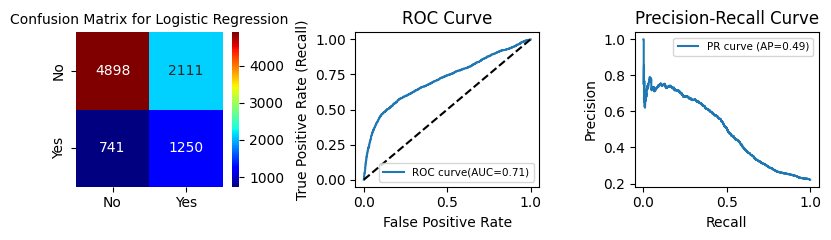

In [92]:
# model=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")
model=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")
model.fit(Ax_train,Ay_train)

# predection on x_test
Ay_pred=model.predict(Ax_test)
Ay_prob=model.predict_proba(Ax_test)[:,1]

# Ay_pred_threshold=(Ay_prob>=Threshold).astype(int)

# model evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model.score(Ax_test,Ay_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(Ay_test,Ay_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(Ay_test,Ay_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(Ay_test,Ay_pred,output_dict=True,target_names=["\u001b[32mNO\u001b[0m", "\u001b[32mYES\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mYES\u001b[0m","\u001b[32mNO\u001b[0m"]:
        model_scores["DataA"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(Ay_test,Ay_pred),annot=True,fmt="d",cmap="jet",label=["No","Yes"],xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})


fpr, tpr, thresholds = roc_curve(Ay_test, Ay_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(Ay_test, Ay_prob)
avg_pr = average_precision_score(Ay_test, Ay_prob)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

In [93]:
Ay_prob=model.predict_proba(Ax_test)

<h5 style="color:cyan">for DataB</h5>

 Logistic Regression Accuracy: 0.6864444444444444
 Accuracy on orignal vs predicted values: 0.6864444444444444
 Confusion Matrix:
 [[4926 2083]
 [ 739 1252]]
 report: 
NO: {'precision': 0.86954986760812, 'recall': 0.7028106719931516, 'f1-score': 0.7773394350639103, 'support': 7009.0}
YES: {'precision': 0.37541229385307345, 'recall': 0.6288297338021095, 'f1-score': 0.4701464513706346, 'support': 1991.0}
accuracy: 0.6864444444444444
macro avg: {'precision': 0.6224810807305967, 'recall': 0.6658202028976306, 'f1-score': 0.6237429432172725, 'support': 9000.0}
weighted avg: {'precision': 0.7602356554585313, 'recall': 0.6864444444444444, 'f1-score': 0.709381520560209, 'support': 9000.0}
----------------------------------------------------------------------------------------------------------------------------------


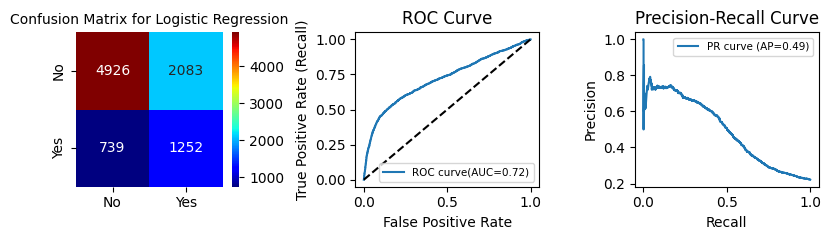

In [94]:
model=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")
model.fit(Bx_train,By_train)

# predection on x_test
By_pred=model.predict(Bx_test)
By_prob=model.predict_proba(Bx_test)[:,1]

# model evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model.score(Bx_test,By_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(By_test,By_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(By_test,By_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(By_test,By_pred,output_dict=True,target_names=["\u001b[32mNO\u001b[0m", "\u001b[32mYES\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mYES\u001b[0m","\u001b[32mNO\u001b[0m"]:
        model_scores["DataB"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(By_test,By_pred),annot=True,fmt="d",cmap="jet",label=["No","Yes"],xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(By_test, By_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(By_test, By_prob)
avg_pr = average_precision_score(By_test, By_prob)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

<h5 style="color:cyan">for DataC</h5>

 Logistic Regression Accuracy: 0.6846666666666666
 Accuracy on orignal vs predicted values: 0.6846666666666666
 Confusion Matrix:
 [[4914 2095]
 [ 743 1248]]
 report: 
NO: {'precision': 0.8686582994520063, 'recall': 0.7010985875303182, 'f1-score': 0.7759355755566082, 'support': 7009.0}
YES: {'precision': 0.37331737959916245, 'recall': 0.6268206931190357, 'f1-score': 0.46794150731158607, 'support': 1991.0}
accuracy: 0.6846666666666666
macro avg: {'precision': 0.6209878395255843, 'recall': 0.6639596403246769, 'f1-score': 0.6219385414340971, 'support': 9000.0}
weighted avg: {'precision': 0.7590778804045606, 'recall': 0.6846666666666666, 'f1-score': 0.7078004433481816, 'support': 9000.0}
----------------------------------------------------------------------------------------------------------------------------------


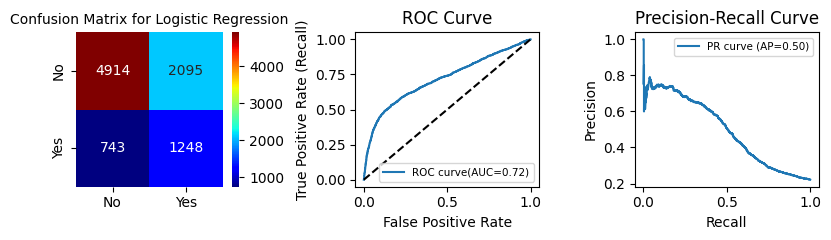

In [95]:
model=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")
model.fit(Cx_train,Cy_train)

# predection on x_test
Cy_pred=model.predict(Cx_test)
Cy_prob=model.predict_proba(Cx_test)[:,1]

# model evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model.score(Cx_test,Cy_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(Cy_test,Cy_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(Cy_test,Cy_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(Cy_test,Cy_pred,output_dict=True,target_names=["\u001b[32mNO\u001b[0m", "\u001b[32mYES\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mYES\u001b[0m","\u001b[32mNO\u001b[0m"]:
        model_scores["DataC"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(Cy_test,Cy_pred),annot=True,fmt="d",cmap="jet",label=["No","Yes"],xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(Cy_test, Cy_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(Cy_test, Cy_prob)
avg_pr = average_precision_score(Cy_test, Cy_prob)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

<h5 style="color:cyan">for DataD</h5>

 Logistic Regression Accuracy: 0.6936111111111111
 Accuracy on orignal vs predicted values: 0.6936111111111111
 Confusion Matrix:
 [[3996 1599]
 [ 607  998]]
 report: 
NO: {'precision': 0.8681294807734087, 'recall': 0.7142091152815013, 'f1-score': 0.7836830751127672, 'support': 5595.0}
YES: {'precision': 0.3842895648825568, 'recall': 0.6218068535825545, 'f1-score': 0.4750118990956687, 'support': 1605.0}
accuracy: 0.6936111111111111
macro avg: {'precision': 0.6262095228279827, 'recall': 0.6680079844320279, 'f1-score': 0.629347487104218, 'support': 7200.0}
weighted avg: {'precision': 0.7602734995227396, 'recall': 0.6936111111111111, 'f1-score': 0.7148751254589557, 'support': 7200.0}
----------------------------------------------------------------------------------------------------------------------------------


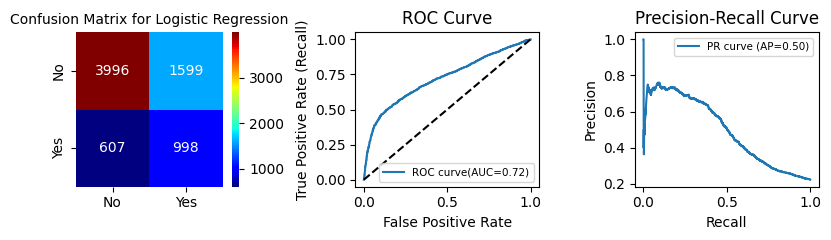

In [96]:
model=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")
model.fit(Dx_train,Dy_train)

# predection on x_test
Dy_pred=model.predict(Dx_test)
Dy_prob=model.predict_proba(Dx_test)[:,1]

# model evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model.score(Dx_test,Dy_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(Dy_test,Dy_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(Dy_test,Dy_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(Dy_test,Dy_pred,output_dict=True,target_names=["\u001b[32mNO\u001b[0m", "\u001b[32mYES\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mYES\u001b[0m","\u001b[32mNO\u001b[0m"]:
        model_scores["DataD"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(Dy_test,Dy_pred),annot=True,fmt="d",cmap="jet",label=["No","Yes"],xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(Dy_test, Dy_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(Dy_test, Dy_prob)
avg_pr = average_precision_score(Dy_test, Dy_prob)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

In [97]:
for name,score in model_scores.items():
    print(name)
    for k,v in score.items():
        print(f"\t{k}:{v}")

DataA
	NO:{'precision': 0.8685937222911864, 'recall': 0.6988158082465402, 'f1-score': 0.7745098039215687, 'support': 7009.0}
	YES:{'precision': 0.3719131210949122, 'recall': 0.6278252134605726, 'f1-score': 0.4671150971599402, 'support': 1991.0}
DataB
	NO:{'precision': 0.86954986760812, 'recall': 0.7028106719931516, 'f1-score': 0.7773394350639103, 'support': 7009.0}
	YES:{'precision': 0.37541229385307345, 'recall': 0.6288297338021095, 'f1-score': 0.4701464513706346, 'support': 1991.0}
DataC
	NO:{'precision': 0.8686582994520063, 'recall': 0.7010985875303182, 'f1-score': 0.7759355755566082, 'support': 7009.0}
	YES:{'precision': 0.37331737959916245, 'recall': 0.6268206931190357, 'f1-score': 0.46794150731158607, 'support': 1991.0}
DataD
	NO:{'precision': 0.8681294807734087, 'recall': 0.7142091152815013, 'f1-score': 0.7836830751127672, 'support': 5595.0}
	YES:{'precision': 0.3842895648825568, 'recall': 0.6218068535825545, 'f1-score': 0.4750118990956687, 'support': 1605.0}


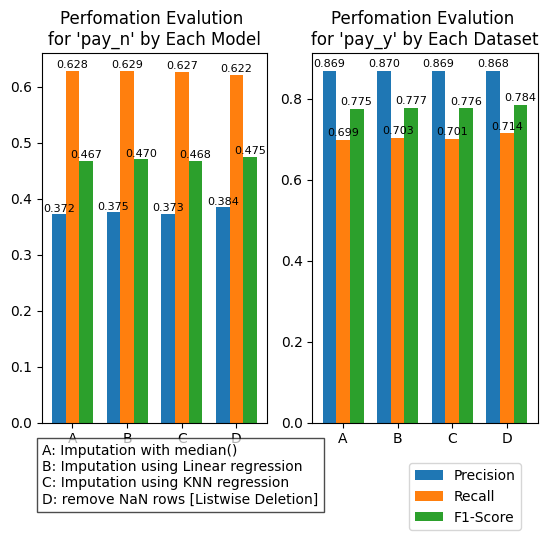

In [98]:
pay_y=[]
pay_n=[]
for name,metric in model_scores.items():
    for k,v in metric.items():
        pay_y.append(v) if k=="YES" else pay_n.append(v)

vp=[d["precision"] for d in pay_y]
vr=[d["recall"] for d in pay_y]
vf1=[d["f1-score"] for d in pay_y]

fp=[d["precision"] for d in pay_n]
fr=[d["recall"] for d in pay_n]
ff1=[d["f1-score"] for d in pay_n]


fig,ax=plt.subplots(1,2)
ax[0].bar([i-0.25 for i in range(len(model_scores))],vp,0.25,label="Precision")
ax[0].bar([i for i in range(len(model_scores))],vr,0.25,label="Recall")
ax[0].bar([i+0.25 for i in range(len(model_scores))],vf1,0.25,label="F1-Score")

ax[0].set_xticks([0,1,2,3])
ax[0].set_xticklabels(["A","B","C","D"],rotation=0)

# ax[0].set_ylim(bottom=0.9,top=1.0)
ax[0].set_title("Perfomation Evalution \nfor 'pay_n' by Each Model")
ax[0].legend(loc="center left", bbox_to_anchor=(1.6, -0.2))

# # add text on bar
for i,x in enumerate(vp):
    ax[0].text(i-0.25,x+0.005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(vr):
    ax[0].text(i,x+0.005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(vf1):
    ax[0].text(i+0.25,x+0.005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

# 2nd axis
ax[1].bar([i-0.25 for i in range(len(model_scores))],fp,0.25,label="Precision")
ax[1].bar([i for i in range(len(model_scores))],fr,0.25,label="Recall")
ax[1].bar([i+0.25 for i in range(len(model_scores))],ff1,0.25,label="f1-Score")

# add text on bar
for i,x in enumerate(fp):
    ax[1].text(i-0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(fr):
    ax[1].text(i,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(ff1):
    ax[1].text(i+0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

ax[1].set_xticks([0,1,2,3])
ax[1].set_xticklabels(["A","B","C","D"],rotation=0)

ax[1].set_title("Perfomation Evalution \nfor 'pay_y' by Each Dataset")

plt.text(-5.5, -0.2, "A: Imputation with median()\nB: Imputation using Linear regression \nC: Imputation using KNN regression\nD: remove NaN rows [Listwise Deletion]", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))

if "assests" not in os.listdir("./"):
    os.makedirs("assests")
plt.savefig(f"./assests/model comparision ({optimizer}_{epoch}_{missing_ratio}).png",bbox_inches="tight")

<h3 style="color:orange">Conclusion</h3>

<h5 style="color:cyan">why DataD performs poor even if Data(A,B,C) were worse</h5>

even thought DataD has perform little better in terms of precision and F1 score than others for lower MAR but as we increas MAr ratio we can observer it perofms poor than others.because by removing all rows with missing values,it can reduce **sample size** and **statistical power**, potentially leading to poor performance, especially when missingness is not completely random.by remove data there are probable chances to remove essitial data which is can be used for data analysis. 

<h5 style="color:cyan">(Liner vs Non-Liner) model regressor</h5>

we can observer that the both model perfomed similar for moderate epochs. as we increase the number of epochs for logistic regression for this data we see **linear model** perfoms better that non-linear model. therfore linear model would be preferable for this type of data. this indecated there is a **codependncy amoung feature** due which  linear model is able to perform well in this case. if there feature were **indepedndet then non-linear model** would perfom well in this case 

<h5 style="color:cyan">best stratgies for handling missing data</h5>

most optimal way to handel missing data would be using **linear model** to predect the missing data. this way we can maintain the relation of within data witput alternign varinance or correlation. where other methods would slight alter the correlation or variance. other than this if data is has a **non-linear dependency** then **non-linear models would outperform** than linear model.